In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import scipy.optimize as opt
import regularized_optimization as reg_opt
import Utilityfunctions as utils
import jax.numpy as jnp
import numpy as np
import jax as jax
import matplotlib.pyplot as plt
from jx import likelihood as lik
jax.config.update("jax_enable_x64", True)

In [2]:
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_EventsAEP.csv"
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_Mut50_Full.csv"
# mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_30and5_Full.csv"
# annot_handle = "../data/paad/G12_PAADPANET_PM_z10_sampleSelection.csv"
#mut_handle = "../data/luad/G13_LUAD_PM_z1_Events_20and8_Full.csv"
#annot_handle = "../data/luad/G13_LUAD_PM_z1_sampleSelection_20and8.csv"
mut_handle = "../data/dummy/events.csv"
annot_handle = "../data/dummy/sample_selection.csv"
annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

# Remove datapoints, that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]
dat.columns

Index(['patientID', 'P.Mut.TP53', 'M.Mut.TP53', 'P.Mut.KRAS', 'M.Mut.KRAS',
       'P.chr5.amp.single.1', 'M.chr5.amp.single.1', 'paired', 'P.AgeAtSeqRep',
       'M.AgeAtSeqRep', 'metaStatus'],
      dtype='object')

In [3]:
start = dat.columns.to_list()[1]
stop = mut_data.columns.to_list()[mut_data.columns.to_list().index("paired") - 1]
mult = dat.set_index(["paired", "metaStatus"])
cleaned = mult.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
cleaned = cleaned.sort_index()
cleaned.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
cleaned.loc[(0, "absent"), "Seeding"] = 0
cleaned.loc[(1, "isPaired"), "Seeding"] = 1
dat_prim_nomet, dat_met_only, dat_prim_met, dat_coupled = utils.split_data(cleaned)
print(dat_prim_nomet.shape[0], dat_prim_met.shape[0], dat_coupled.shape[0], dat_met_only.shape[0])

6 92 19 74


In [4]:
events = []
for elem in cleaned.columns.to_list()[::2]:
    iwas = elem.split(".")
    if len(iwas) > 2:
        if iwas[1]  == 'Mut':
            events.append(iwas[2] + " (M)")
        else:
            events.append(iwas[1] + " (" + iwas[2] + ")")
    elif len(iwas) == 2:
        events.append(iwas[1])
    else:
        events.append("Seeding")

In [5]:
rai = cleaned.loc[(0, "absent"),:]
print(cleaned.loc[(0, "absent")].iloc[:,0:-1:2])
cleaned.loc[(0, "absent")].iloc[:,0:-1:2].sum(axis=0)/cleaned.loc[(0, "absent")].shape[0]

                   P.Mut.TP53  P.Mut.KRAS  P.chr5.amp.single.1
paired metaStatus                                             
0      absent               0           1                    1
       absent               1           0                    0
       absent               1           0                    0
       absent               0           1                    1
       absent               1           0                    0
       absent               0           1                    0


P.Mut.TP53             0.500000
P.Mut.KRAS             0.500000
P.chr5.amp.single.1    0.333333
dtype: float64

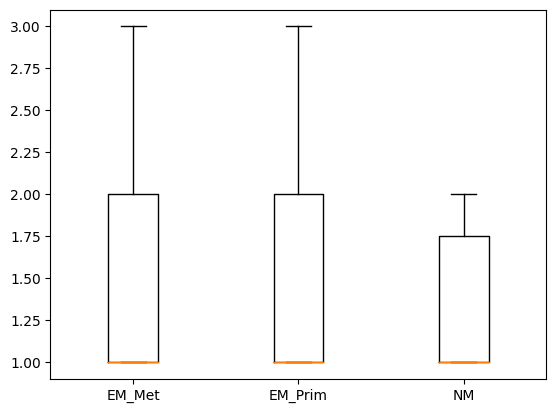

In [6]:
iwas = {"EM_Met":cleaned.loc[(0, "isMetastasis")].iloc[:, 1::2].sum(axis=1), 
        "EM_Prim":cleaned.loc[(0, "present")].iloc[:, 0:-1:2].sum(axis=1),
        "NM":cleaned.loc[(0, "absent")].iloc[:, 0:-1:2].sum(axis=1)}

fig, ax = plt.subplots()
ax.boxplot(iwas.values())
ax.set_xticklabels(iwas.keys())
plt.show()

In [7]:
n = (cleaned.shape[1]-1)//2
n += 1
lam1_start = np.log(30/162)
lam2_start = np.log(30/162) # observed mean time to second diagnosis is 87/162 days
indep = utils.indep(jnp.vstack((dat_met_only, dat_prim_met, dat_prim_nomet)), dat_coupled)
start_params = np.append(indep, [lam1_start, lam2_start])

In [8]:
utils.cross_val(cleaned, np.linspace(0.0001, 0.01, 5), 5, start_params, 0.8, n)

Crossvalidation started
Diag constrained, Split: 0.0001, Fold: 0, Score: 2.4079261800478537
Diag unconstrained, Split: 0.0001, Fold: 0, Score: 2.389317749297197
Diag constrained, Split: 0.002575, Fold: 0, Score: 2.4594164283937965
Diag unconstrained, Split: 0.002575, Fold: 0, Score: 2.4193358494199875
Diag constrained, Split: 0.005050000000000001, Fold: 0, Score: 2.4815563532701246
Diag unconstrained, Split: 0.005050000000000001, Fold: 0, Score: 2.4449674836711104
Diag constrained, Split: 0.007525000000000001, Fold: 0, Score: 2.491171582496002
Diag unconstrained, Split: 0.007525000000000001, Fold: 0, Score: 2.465132581187201
Diag constrained, Split: 0.01, Fold: 0, Score: 2.4936239444816866
Diag unconstrained, Split: 0.01, Fold: 0, Score: 2.479078488796307
Diag constrained, Split: 0.0001, Fold: 1, Score: 4.768341500380563
Diag unconstrained, Split: 0.0001, Fold: 1, Score: 6.1673483724131035
Diag constrained, Split: 0.002575, Fold: 1, Score: 4.453741882114638
Diag unconstrained, Split: 0

KeyError: 'absent'

In [9]:
n_mod = n-1
arr = dat_coupled * np.array([1,2]*n_mod+[1])
arr = arr @ (np.diag([1,0]*n_mod+[1]) + np.diag([1,0]*n_mod, -1))
counts = np.zeros((6, n))
for i in range(0,2*n,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]
    counts[4, i_h] = (np.sum(dat_prim_met[:, i], axis=0))/dat_prim_met.shape[0]
    counts[5, i_h] = (np.sum(dat_met_only[:, i+1], axis=0))/dat_met_only.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
          ["NM ("+str(dat_prim_nomet.shape[0])+")"] +\
          ["EM-PT ("+str(dat_prim_met.shape[0])+")"] +\
          ["EM-MT ("+str(dat_met_only.shape[0])+")"],
          ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
iwas = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
#iwas.to_latex("luad_samples.tex")
iwas

Coupled (19)                    NM (6) EM-PT (92) EM-MT (74)
             PT-Private MT-Private Shared Present    Present    Present
TP53 (M)           0.05       0.11   0.58    0.50       0.68       0.70
KRAS (M)           0.11       0.05   0.05    0.50       0.34       0.23
chr5 (amp)         0.16       0.42   0.26    0.33       0.41       0.41
Seeding            1.00       0.00   0.00    0.00       1.00       1.00

In [10]:
penal1 = 0.005 # L1 penalty on off-diagonals
penal2 = 0.005 # L2 penalty on diagonals
m_p_corr = 0.8
x = opt.minimize(reg_opt.value_grad, x0 = start_params, args = (dat_prim_nomet, dat_coupled, dat_prim_met, dat_met_only, n-1, penal1, penal2,  m_p_corr), 
                method = "L-BFGS-B", jac = True, options={"maxiter":10000, "disp":True, "ftol":1e-04})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02797D+01    |proj g|=  9.93120D+00


 This problem is unconstrained.



At iterate    1    f=  5.65083D+00    |proj g|=  1.65685D+00

At iterate    2    f=  5.16557D+00    |proj g|=  1.17952D+00

At iterate    3    f=  3.65084D+00    |proj g|=  3.99997D-01

At iterate    4    f=  3.13223D+00    |proj g|=  1.48598D-01

At iterate    5    f=  3.04530D+00    |proj g|=  1.33878D-01

At iterate    6    f=  2.86596D+00    |proj g|=  1.04315D-01

At iterate    7    f=  2.81164D+00    |proj g|=  5.32437D-02

At iterate    8    f=  2.79778D+00    |proj g|=  3.24660D-02

At iterate    9    f=  2.78208D+00    |proj g|=  1.64299D-02

At iterate   10    f=  2.77670D+00    |proj g|=  1.68078D-02

At iterate   11    f=  2.77475D+00    |proj g|=  2.43852D-02

At iterate   12    f=  2.77234D+00    |proj g|=  1.19947D-02

At iterate   13    f=  2.77034D+00    |proj g|=  1.11598D-02

At iterate   14    f=  2.76754D+00    |proj g|=  9.02773D-03

At iterate   15    f=  2.76302D+00    |proj g|=  2.37365D-02

At iterate   16    f=  2.75936D+00    |proj g|=  1.83860D-02

At iter

In [ ]:
print(1/jnp.exp(x.x[-2]))
df2 = pd.DataFrame(x.x[:-2].reshape((n, n)), columns=events, index=events)
theta = df2.copy()
df2["Sampling"] = np.append(np.array(x.x[-2:]), np.zeros(n-2))
df2.to_csv("../results/test.csv")
df2.round(3)

In [ ]:
utils.plot_theta(theta, 0.5)